In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 50)
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.inspection import plot_partial_dependence
from sklearn import tree
from xgboost import XGBClassifier, plot_importance

# Oppgave 1

In [2]:
titanic_df = pd.read_csv("../data/train.csv")

In [3]:
display(titanic_df)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [4]:
titanic_df["NaN_Age"] = titanic_df["Age"].isnull().astype(int)
titanic_df["Age"] = titanic_df.groupby(["Pclass", "Sex"])["Age"].apply(lambda x: x.fillna(x.median()))

Denne neste kodeblokken prøver å dele informasjon om kabinen i et nummer og en bokstav. Her antar jeg at det er noe forhold mellom tall- og bokstavkombinasjon, og plassering, og med plassering og sjanse for å overleve.

In [5]:
# Make NaN values into "N0", so that elementwise __item__(0) and __item__(1:)
# returns either the first letter or 'N', or the number or '0' respectively
titanic_df["Cabin"] = titanic_df["Cabin"].fillna("N0")
titanic_df["Cabin_Letter"] = titanic_df["Cabin"].apply(lambda x: x[0])

# Here, it gets a bit trickyer because some people have several rooms
# This means I have to use regexp to get just the first one, and throw the others away
# I assume number of rooms is correlated with columns like fair, and that it therefore
# isn't very important. There are also not that many people that have several rooms,
# so using that data runs the risk of overfitting
titanic_df["Cabin_Number"] = titanic_df["Cabin"].str.extract(r"\w(\d{1,3})\s?.*")
titanic_df["Cabin_Number"].fillna(0, inplace=True)
titanic_df["Cabin_Number"] = titanic_df["Cabin_Number"].astype(int)

Her gjør jeg noen variabler kategoriske. Det kan være at kabinbokstaven bør være numerisk snarere enn
kategorisk, fordi dekkene er oppå hverandre, og det kan være at høyde er den viktige delen.
Fordi jeg ikke vil se nærmere på dekkplasseringen, gjør jeg det bare på denne måten.

In [6]:
categorical_cols = ["Cabin_Letter", "Sex", "Embarked"]
titanic_df = pd.get_dummies(titanic_df, columns=categorical_cols, prefix=categorical_cols, prefix_sep='_')

In [7]:
X = titanic_df[["Pclass", "Age", "NaN_Age", "SibSp", "Parch", "Fare", "Sex_female",
               "Cabin_Number", "Cabin_Letter_A", "Cabin_Letter_B", "Cabin_Letter_C",
               "Cabin_Letter_D", "Cabin_Letter_E", "Cabin_Letter_F", "Cabin_Letter_G",
               "Cabin_Letter_N", "Cabin_Letter_T", "Embarked_C", "Embarked_Q", "Embarked_S"]]
y = titanic_df["Survived"]

In [8]:
display(X)

,Pclass,Age,NaN_Age,SibSp,Parch,Fare,Sex_female,Cabin_Number,Cabin_Letter_A,Cabin_Letter_B,Cabin_Letter_C,Cabin_Letter_D,Cabin_Letter_E,Cabin_Letter_F,Cabin_Letter_G,Cabin_Letter_N,Cabin_Letter_T,Embarked_C,Embarked_Q,Embarked_S
0,3,22.0,0,1,0,7.2500,0,0,0,0,0,0,0,0,0,1,0,0,0,1
1,1,38.0,0,1,0,71.2833,1,85,0,0,1,0,0,0,0,0,0,1,0,0
2,3,26.0,0,0,0,7.9250,1,0,0,0,0,0,0,0,0,1,0,0,0,1
3,1,35.0,0,1,0,53.1000,1,123,0,0,1,0,0,0,0,0,0,0,0,1
4,3,35.0,0,0,0,8.0500,0,0,0,0,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,2,27.0,0,0,0,13.0000,0,0,0,0,0,0,0,0,0,1,0,0,0,1
887,1,19.0,0,0,0,30.0000,1,42,0,1,0,0,0,0,0,0,0,0,0,1
888,3,21.5,1,1,2,23.4500,1,0,0,0,0,0,0,0,0,1,0,0,0,1
889,1,26.0,0,0,0,30.0000,0,148,0,0,1,0,0,0,0,0,0,1,0,0


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Oppgave 2

In [10]:
def sigmoid(x):
    """Sigmoid function, S(x) = 1/(1 + exp(-x))"""
    
    return 1/(1 + np.exp(-x))

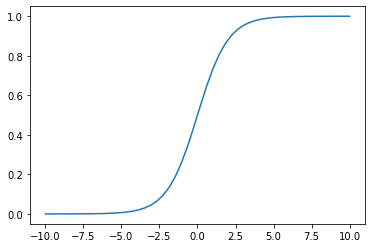

In [11]:
x = np.linspace(-10, 10)
y = sigmoid(x)

plt.plot(x, y)

Sigmoid-funksjonen fungerer godt for binære klassifikasjonsproblemer fordi $\lim_{x \rightarrow \infty} \sigma(x) = 1$ og $\lim_{x \rightarrow -\infty} \sigma(x) = 0$.

In [12]:
def logistic_regression(X, weights, bias):
    """Perform logistic regression on data
    
    :param X: np.ndarray with data
    :param weights: Weights. Has to be as many as there are columns in X.
    :param biases: Biases. Has to be as many as there are columns in X.

    :return: np.array with probabilities.
    """
    
    return sigmoid(X @ weights + bias)


def initialise_weights_and_biases(n):
    """Initialises weights with standardnormal distribution by default, and biases as zeros.
    
    :param n: Number of weights to be generated.
    
    :return: Tuple with weights as np.array with n elements, and bias
    """
    
    weights = np.random.randn(n)
    bias = 0
    
    return weights, bias


def cross_entropy_logistic_gradient(X, y, y_hat, *parameters):
    """Computes gradient for parameters in logistic regression.
    
    :param X: np.ndarray with predictor data.
    :param y: np.array with target.
    :param y_hat: np.array of same shape as y, with predictions.
    :param *parmeters: Tuple of weights and bias. Used *args for compatibility.
    
    :return: Tuple of gradients for weights and bias.
    """
    delta = -(y - y_hat) / y.shape[0]

    dCdW = X.T @ delta
    dCdb = np.sum(delta, axis = 0)
    
    return dCdW, dCdb


def cross_entropy_loss(y, y_hat):
    """Computes cross entropy loss."""
    
    return - np.mean(y*np.log(y_hat+1e-13) + (1 - y)*np.log(1 - y_hat + 1e-13))

def train(X,
          y,
          *parameters,
          iterations=100,
          learning_rate=0.01,
          method=logistic_regression,
          gradient_func=cross_entropy_logistic_gradient,
          loss=cross_entropy_loss):
    """Trains some function estimator.
    
    :param X: np.ndarray with predictor data.
    :param y: np.ndarray with target data.
    :param *parameters: Training parameters (like weights and biases) to start with.
    :param iterations: Number of iterations to train for. 100 by default.
    :param learning_rate: Default is 0.01.
    :param method: Function with signature like `method(X, *parameters)`, that returns
                   np.array with predicted values. logistic_regression by default.
    :param gradient_func: Function that evaluates loss after a step, and returns tuple of 
                          np.array with gradients for parameters. Signature must be
                          `gradient_func(X, y, y_hat, *parameters)`. Default is
                          cross_entropy_logistic_gradient.
    :param loss: Function that returns loss. Not used for training, just for returning loss
                 after each iteration. Default is cross_entropy_loss.
    
    :return: Tuple with the first element being the updated parameters, and the second being
             the loss after each step. 
    """
    losses = np.zeros(iterations)
    for i in range(iterations):
        y_hat = method(X, *parameters)
        
        losses[i] = loss(y, y_hat)
        
        gradients = gradient_func(X, y, y_hat, *parameters)
        
        for parameter, gradient in zip(parameters, gradients):
            parameter -= learning_rate * gradient
    
    return parameters, losses

In [13]:
weights, bias = initialise_weights_and_biases(X_train.to_numpy().shape[1])
parameters, losses = train(X_train.to_numpy(), y_train.to_numpy(), weights, bias, iterations=10000, learning_rate=0.0025)

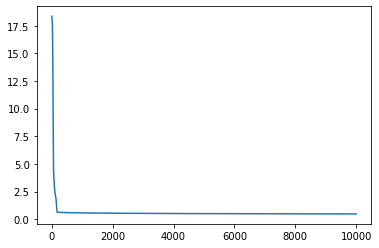

In [14]:
plt.plot(losses)

In [15]:
y_hat_test_log = np.round(logistic_regression(X_test.to_numpy(), *parameters))
accuracy_log = accuracy_score(y_test, y_hat_test_log)
print(f"Accuracy = {accuracy_log:.2%}")

Accuracy = 78.21%


# Oppgave 3

In [16]:
clf = DecisionTreeClassifier(max_depth=3)
clf.fit(X_train, y_train)
y_hat_test_tree = clf.predict(X_test)
accuracy_tree = accuracy_score(y_test, y_hat_test_tree)
print(f"Accuracy = {accuracy_tree:.2%}")

Accuracy = 84.36%


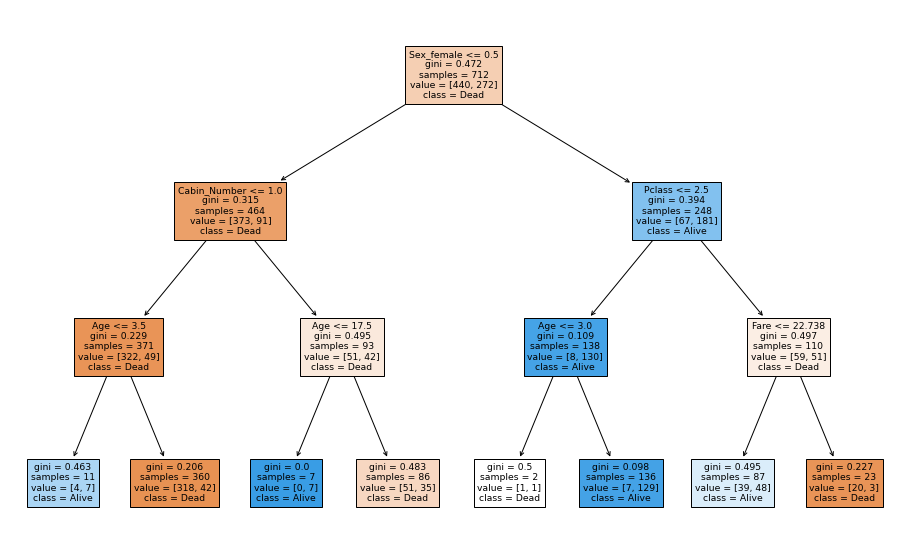

In [17]:
plt.figure(figsize=(16,10))
tree.plot_tree(clf, max_depth=3, feature_names=X.columns, class_names=["Dead", "Alive"], filled=True)
plt.show()

Det ser ut som om accuracy'en til et beslutningstre med maksdybde = 3 er noe høyere enn for logistisk regresjon. Det ser likevel ut som om den har gjort noen rare valg som skriker overfitting (som at noden i det nest nederste nivået, helt til venstre, sjekker om alderen er over eller under 0.915, og finner bare fire personer som er under det, som alle overlever. Kjønn ser ut til å være den desidert viktigste faktoren ifølge dette treet, med alder og billettype som andre vikige faktorer.

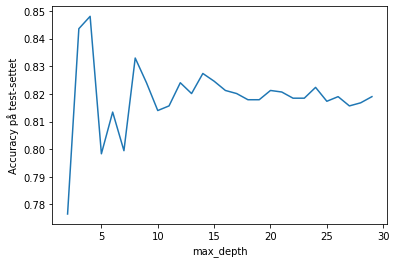

In [18]:
iterations = range(10)
max_depths = range(2, 30)
accuracies = np.zeros((len(iterations), len(max_depths)))
for i in iterations:
    for e, max_depth in enumerate(max_depths):
        clf = DecisionTreeClassifier(max_depth=max_depth)
        clf.fit(X_train, y_train)
        y_hat_test_tree = clf.predict(X_test)
        accuracies[i][e] = accuracy_score(y_test, y_hat_test_tree)

plt.plot(max_depths, np.mean(accuracies, axis=0))
plt.xlabel("max_depth")
plt.ylabel("Accuracy på test-settet")
plt.show()

Hvis vi endrer max_depth har vi stor varians i hvor mye bedre/verre vi blir, men det ser ut som om 3 er et godt nivå, og at vi raskt overfitter med høyere max_depths en det. For den veldig diskrete formen for maskinlæring som beslutningstrær er, tror jeg å dele alle dekkene i kategoriske variabler er uegnet. Med en mer numerisk variabel hadde vi kunne skilt mellom dekk over og under et sted for eksempel, og det kunne vært nyttig.

# Oppgave 4

In [19]:
model = XGBClassifier(learning_rate = 0.01, max_depth = 3, objective = "binary:logistic", n_estimators = 1000)
model = model.fit(X_train, y_train)

Y_mdl = model.predict(X_test)

/Users/didrik/.local/share/virtualenvs/oblig01-c-tTRkd0/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:00:41] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


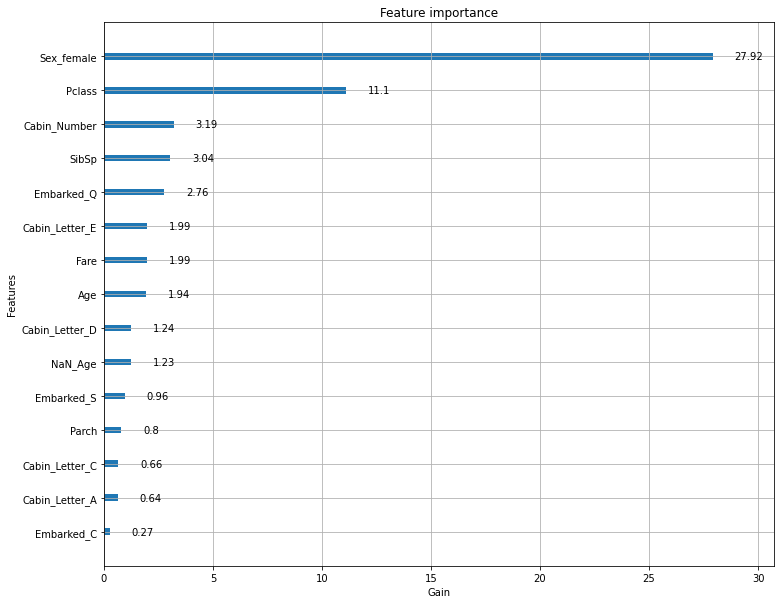

In [20]:
fig = plt.figure(figsize=(12, 10))
ax = plt.subplot()
gain = model.get_booster().get_score(importance_type="gain")
for key in gain.keys(): # Dette er kun for å runde av tall så det blir mer lesbart
    gain[key] = round(gain[key], 2)
ax = plot_importance(gain, ax=ax, importance_type="gain", xlabel="Gain")

Her ser vi at kjønn og passasjerklasse er de desidert viktigste faktorene xgboost-modellen bruker for å bestemme om noen overlever eller ikke. Etter det kommer kabinnummer og antall som reiser sammen. At kabinnummer er så viktig peker i rettning av at det var lurt å lage en variabel av det, og at noen av kabinbokstavene faktisk også ikke er helt uviktige viser at det må være noe nyttig informasjon der. Jeg tror en kombinasjon av disse hadde vært kraftfull, fordi det nå er vanskelig å se på sammenhengen mellom de to.

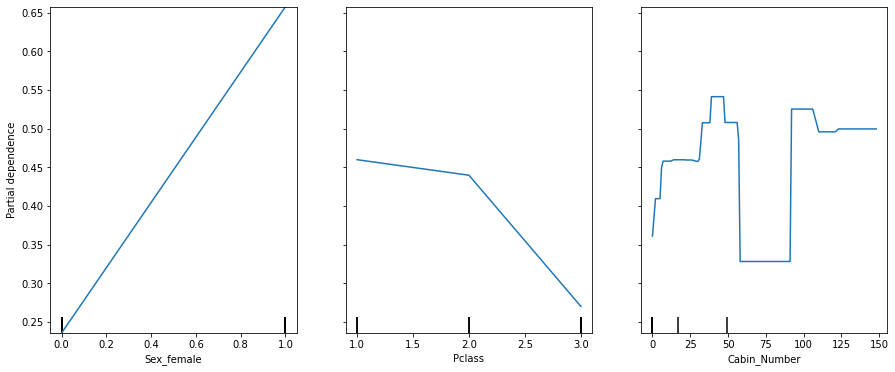

In [21]:
features = ["Sex_female", "Pclass", "Cabin_Number"]

plot_partial_dependence(model, X_train, features)
plt.gcf().set_size_inches(15, 6)
plt.show()

I kabinnummer-grafen ser det ut som om sjansen for å overleve var høyest rundt rom 100, og mellom rom 30 og 60. Her er det likevel stor varians mellom forskjellige kjøringer, så det er vanskelig å konkludere ut fra denne informasjonen. Det er mulig e eneste trærne som bruker kabinnummer konsek